<script>
    var code_show=true; //true -> hide code at first

    function code_toggle() {
        $('div.prompt').hide(); // always hide prompt

        if (code_show){
            $('div.input').hide();
        } else {
            $('div.input').show();
        }
        code_show = !code_show
    }
    $( document ).ready(code_toggle);
</script>

<center>
<h1>5th Sardinian International Summer School Workshop</h1><br><br>
<i><big>Sequencing-based next generation association studies</big><br><br>
Eleftheria Zeggini, Sophie Hackinger (sh29@sanger.ac.uk), Arthur Gilly (ag15@sanger.ac.uk)</i>
</center>

## Objectives
In this workshop, you will learn the basic skills needed to perform next-generation association studies, from file format manipulation to filtering, single-point association, meta-analysis and visualisation of results.
<br><br>

<figure>
  <img src="../materials/Workflow.jpg" width="80%" alt="" />
  <figcaption><i><center>Fig. 1: Workflow of the different analysis stages covered in the workshop</center></i></figcaption>
</figure>




## Background : from sequencing reads to variant formats
Sequencing data come in the form of reads of a constant length, usually 100 base pairs for Next Generation Sequencing (NGS). They are usually stored in the [FASTQ](https://en.wikipedia.org/wiki/FASTQ_format) format. These reads are then aligned to a reference sequence, one continuous representation of all chromosome sequences for a given species. Reference sequences are stored in the [FASTA](https://en.wikipedia.org/wiki/FASTA_format) format. This task is performed by an aligner, which we won't cover in this workshop. [BWA](http://bio-bwa.sourceforge.net) (in particular the optimised `bwa mem` algorithm) is a popular aligner. 
<br> <br>
 Aligners usually produce binary files in [BAM](https://samtools.github.io/hts-specs/SAMv1.pdf) format, which can be manipulated using the [samtools](http://www.htslib.org/doc/samtools.html) software package. Aligned reads are then piled up on top of each other and compared to the reference sequence, by a variant caller such as [GATK](https://www.broadinstitute.org/gatk/) or [samtools](http://www.htslib.org/doc/samtools.html). A probabilistic model is used to examine the positions where the reads disagree with the reference. If confidence is good, then a variation is called at that site, and the confidence is reported in the output file.

<figure>
  <img src="https://jchoigt.files.wordpress.com/2012/07/igv_e217g_snapshot.png" width="60%" alt="" />
  <figcaption><i><center>Fig. 2: Read pileup in BAM format, visualised using [IGV](https://www.broadinstitute.org/igv)</center></i></figcaption>
</figure>

### The VCF format
VCF is the main output format for most variant callers. It is very thorougly described in the official [VCF file format specification](http://www.1000genomes.org/wiki/Analysis/vcf4.0). Every file is composed of a multi-line header prefixed by `##`, then a main header line prefixed by `#` which describes the fields. The first 9 fields/columns are common to all VCF files, then there is one column per sample. 

| |Name|Description|
|-|-|
|1|CHROM|The name of the sequence (typically a chromosome) on which the variation is being called.|
|2|POS|The 1-based position of the variation on the given sequence.|
|3|ID|The identifier of the variation, e.g. a dbSNP rs identifier or just . if unknown. Multiple identifiers should be separated by semi-colons without white-space.|
|4|REF|The reference base.|
|5|ALT|The list of alternative alleles at this position, separated by commas.|
|6|QUAL|A quality score associated with the inference of the given alleles.|
|7|FILTER|A flag indicating which of a given set of filters the variation has passed.|
|8|INFO|An extensible list of key-value pairs (fields) describing the variation.  Multiple fields are separated by semicolons with optional values in the format: "<key>=[,data]".|
|9|FORMAT|An (optional) extensible list of fields for describing the samples.|
|10+|SAMPLE|For each (optional) sample described in the file, values are given for the fields listed in FORMAT|
<br><br>

VCF files are usually compressed in the GZIP format. VCF files end with the `.vcf` extension, compressed VCF files end with `.vcf.gz`.

<br>

<div class="alert alert-success"><b>Question 0:</b>  Open the training file for chromosome 21 (location below) and familiarise yourself with its structure. What is the genotype of individual HG00105 for  SNP rs71235073 ? How many fields are defined in the <code>FORMAT</code> column? Which other fields might we have found there? 
</div>

**Answer:**
`zless -S` is designed to make browsing gzipped files with very long lines easier.

First, we identify which column corresponds to the individual `HG00105`, then we look for `rs71235073` and look at the relevant column:

<button type="button" class="btn btn-primary" onClick="code_toggle()">Click here to show/hide answer</button>


`grep` is a famous program that returns all lines matching a certain pattern. `zgrep` is the version for gzipped files. `-m 1` instructs `grep` to stop after the first match (the file is big and it would take time to look through the whole of it). `cut` is a tool that selects columns in a file (here, 10th and above). The `tr` command replaces every occurrence of a character by another (here, tabs with newlines).


In [1]:
%%bash # ignore this line!
zgrep -m 1 HG00105 ../data/Step1/cohort1.chr21.vcf.gz | tr '\t' '\n' | grep -n HG00105
zgrep -m 1 rs71235073 ../data/Step1/cohort1.chr21.vcf.gz | cut -f13

bash: #: No such file or directory



<hr>



## Step 1 : Processing variant calling data from sequencing
<br>
<div class="alert alert-warning"><b>Location:</b> Input files for this step are located in the <code>Step1</code> folder.</div>
<br>
<div class="alert alert-info"><b>Note:</b> In this workshop, we will concentrate on chromosomes 21 and 22 to speed up analyses, but all the commands below easily translate genome-wide.</div>

### Filtering based on quality
Variant callers attribute a quality value to each variant (in the 6th field of the VCF, `QUAL`). Filtering based on variant quality is the basis of variant-level QC. For this training, we want to greatly thin the dataset so that our calculations run faster. Therefore, we are going to be very stringent (in a real life scenario, we might use more relaxed thresholds).
<br>
<br>
<div class="alert alert-success"><b>Question 1:</b>  Using `bcftools filter` or  `bcftools view`, remove all sites with a quality less than $150$. How many variants did we exclude, in absolute counts and in proportion of the total?</div>

**Answer:**

```bash
bcftools view -Oz -o cohort1.filtered.vcf.gz -e '%QUAL<150' training.vcf.gz 
```

There are several ways to count the numbers of sites in a VCF. The easiest, but slowest to run is with `bcftools stats` which gives a complete report on sites, individuals and quality. But Linux has a lot of tools that make analyses such as this easier.

One way to count sites in a VCF:

```bash
zgrep -v '^#' cohort1.filtered.vcf.gz | wc -l
```

The `^#` in the `grep` means "lines starting with a #" and the `-v` inverts the match (printing only non-matching lines). `wc -l` counts lines in the output.

<hr>
<br>
<br>
<div class="alert alert-success"><b>Bonus question:</b>  Extract the qualities in the <code>QUAL</code> field for 5000 variants using <code>bcftools</code> and visualise the distribution. Which <code>QUAL</code> threshold would you use to keep 99% of variants? (Use the <code>quantile</code> or <code>ecdf</code> functions in <code>R</code>)</div>

**Answer:**

```bash
bcftools query -f '%QUAL\n' cohort1.vcf.gz | head -n 5000 > cohort1.vcf.5000.qualities
```

Then in R:

```R
qualities=read.table("cohort1.vcf.5000.qualities", header=F)
plot(ecdf(qualities$V1))
quantile(qualities$V1, 0.01)
```
<hr>


## Step 2 : Converting VCF to association-ready files
<br>
<div class="alert alert-warning"><b>Location:</b> Input files for this step are located in the <code>Step2</code> folder.</div>

VCF is the main format for reporting variant sites from sequencing data, but few programs support it directly as input. We will use [PLINK](https://www.cog-genomics.org/plink2/), a versatile program that is widely used to manipulate file formats and perform basic analyses. It uses the well-known [Plink](https://www.cog-genomics.org/plink2/formats#ped) and [binary Plink](https://www.cog-genomics.org/plink2/formats#bed) formats.

### Filtering out monomorphics and singletons

Monomorphics are SNPs which do not exhibit variation in the population. They are not informative for association studies and also slow analyses down. Singletons are often excluded from analyses because they are usually associated with bad variant quality, however this step is more relevant to GWAS data than sequencing, since the QUAL filtering step is already supposed to remove bad-quality variants.

<div class="alert alert-success"><b>Question 2:</b>  Find the number of samples in our VCF, then calculate the minor allele frequency of a singleton. Using <code>PLINK</code>, convert both files to <a href="https://www.cog-genomics.org/plink2/formats#bed">BED format</a>, then filter out monomorphics and singletons.</div>

**Answer:**

If you ran `bcftools stats`, you already have access to the number of samples. If not, we can simply count columns in our VCF files.

``` bash
zgrep -m1 '#CHROM' cohort1.chr22.vcf.gz | cut -f10- | tr '\t' '\n' | wc -l
```


This gives us a sample number of $300$ and a minor allele frequency of $\frac{1}{2\times300}=0.0016$. Therefore, we can filter using a minimum minor allele frequency of 0.002. 

```bash
plink --vcf cohort1.chr22.filtered.vcf.gz --maf 0.002 --double-id --make-bed --out cohort1.chr22
plink --vcf cohort1.chr21.filtered.vcf.gz --maf 0.002 --double-id --make-bed --out cohort1.chr21
```


### Merging both chromosomes
<br>
<div class="alert alert-warning"><b>Location:</b> Input files for this step are located in the <code>Step2/merge</code> folder.</div>

<div class="alert alert-success"><b>Bonus question (if interested in potential issues when merging files):</b>  So far we have used two files, one for each chromosome. We will now merge them to make analyses simpler. Use <code>PLINK</code> to convert both files to <a href="https://www.cog-genomics.org/plink2/formats#bed">BED format</a>, then merge them using the <code>--bmerge</code> flag.</div>
<div class="alert alert-info"><b>Note:</b> Usually, for bigger, real datasets, we try to avoid merging for as long as possible, to enable parallel processing of the data. It is common to even subdivide chromosomes into smaller chunks and process each chunk separately. This allows to perform only one, computer-intensive merge step at the end.</div>

**Answer:**

First, we convert VCF to BED (binary Plink), then we merge.

```
plink --bfile cohort1.chr22 --double-id --make-bed --out cohort1.chr22
plink --bfile cohort1.chr21 --double-id --make-bed --out cohort1.chr21
plink --bfile cohort1.chr22 --bmerge cohort1.chr21 --make-bed --out cohort1
```

The last step fails with an error:
```
Error: 31 variants with 3+ alleles present.
* If you believe this is due to strand inconsistency, try --flip with
  cohort1-merge.missnp.
  (Warning: if this seems to work, strand errors involving SNPs with A/T or C/G
  alleles probably remain in your data.  If LD between nearby SNPs is high,
  --flip-scan should detect them.)
* If you are dealing with genuine multiallelic variants, we recommend exporting
  that subset of the data to VCF (via e.g. '--recode vcf'), merging with
  another tool/script, and then importing the result; PLINK is not yet suited
  to handling them.
```

This tells us that 31 variants are present with the same ID in both chromosomes. This is a mistake and those variants with ambiguous IDs should be removed from both datasets. Fortunately Plink stores the conflicting IDs of SNPs to exclude in files with the `.missnp` extension.

```
plink --bfile cohort1.chr22 --double-id --make-bed --exclude cohort1-merge.missnp --out cohort1.chr22
plink --bfile cohort1.chr21 --double-id --make-bed --exclude cohort1-merge.missnp --out cohort1.chr21
plink --bfile cohort1.chr22 --bmerge cohort1.chr21 --make-bed --out cohort1
```

<hr>

<div class="alert alert-success"><b>Bonus question :</b> How many further SNPs might we want to exclude, and for what reason?</div>

### Running the association
<br>
<div class="alert alert-warning"><b>Location:</b> Input files for this step are located in the <code>Step2/assoc</code> folder.</div>

<div class="alert alert-success"><b>Question 3:</b>  Now, we want to perform genetic association in our cohort with a phenotype of interest stored in the <code>cohort1.pheno</code> file. Run the association using <code>PLINK</code></div>

**Answer:**


Now that we have input files, we can add the phenotype with `--pheno` (feel free to have a look what the phenotype file looks like), and run the association with the `--assoc` flag.

```bash
plink --bfile cohort1 --allow-no-sex --pheno cohort1.pheno --assoc --out cohort1
```

This will produce an output file in the [`qassoc`](https://www.cog-genomics.org/plink2/formats#qassoc) format ("q" stands for quantitative, as our trait is not binary).

PLINK association reports are very well-readable by humans, but not so by other programs (mainly because it adds spaces to display rows in an orderly fashion). Let's take some time to make our file more computer-friendly.

```bash
sed -i 's/ \+/ /g' cohort1.qassoc
```

Then run the following line (it adds the alleles for each variant to the output file, which is required for meta-analysis):

```bash
cat <(echo -e "CHR SNP BP NMISS BETA SE R2 T P A1 A2") <(join -1 2 -2 1 <(sort -k2,2 cohort1.qassoc)\
<(cut -f2,5,6 ../assoc/cohort1.bim | sort -k1,1)) | tr ' ' '\t' > temp
mv temp cohort1.qassoc
```

<hr>


### Visualising association results

<div class="alert alert-warning"><b>Location:</b> Input files for this step are located in the <code>Step2/plots</code> folder.</div>

Now that we have a results file, we would like to see whether we have a signal, but we would also like to check that everything ran fine and that we didn't make any mistakes in the study design.
There are two main plots used after an association run:

* **The Manhattan Plot** displays the p-values across the genome and allows to easily spot signals (peaks).
* **The Quantile-Quantile (QQ)** plot is essentially a diagnosis plot. It compares the distribution of p-values against a uniform (expected) distribution. Any deviation from the expected is indicative of an issue (sample relatedness or overlap, non-normality of phenotype values, etc...)

<br>

<div class="alert alert-success"><b>Question 4:</b>  Use the <code>fread</code> function from the <code>data.table</code> package to read the file. Plot a QQ-plot for the association p-values using <code>qqunif</code> from the <code>gap</code> package or <code>qq</code> from the <code>qqman</code> package.</div>

**Answer:**  (please omit the `%%R` at the beginning)

<button type="button" class="btn btn-primary" onClick="code_toggle()">Click here to show R Code</button>

In [3]:
%%R
library(data.table)
library(qqman)

d=fread("../data/cohort1.qassoc")
d=data.frame(d[,V10:=NULL])
qq(d$P)

If you choose to use `gap`, the code is very similar:

```R
library(gap)
qqunif(d$P)
```

<hr>

<div class="alert alert-success"><b>Question 5:</b>  Manhattan plots can be drawn as easily using the <code>manhattan</code> function in the <code>qqman</code> package. Let's try to generate the plot ourselves using R base functions. For both chromosomes, plot $-log_{10}(p)$ as a function of chromosome position.
</div>


**Answer:** 

<button type="button" class="btn btn-primary" onClick="code_toggle()">Click here to show R Code</button>


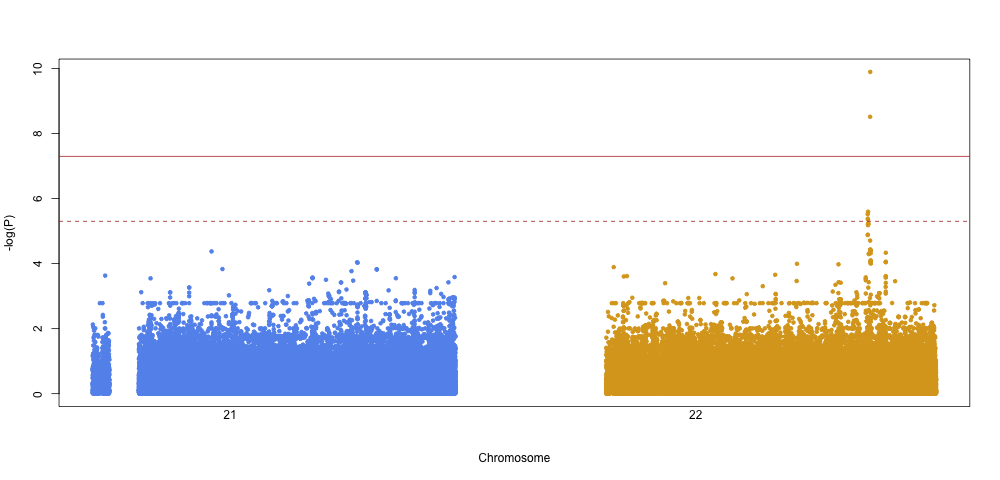

In [11]:
%%R -w 1000 ## ignore this line

## Define colors for each chromosome 
## (a list is available at www.stat.columbia.edu/~tzheng/files/Rcolor.pdf)

colors=c("cornflowerblue", "goldenrod")

## We must create a common x-axis for positions on both chromosomes
d$BP_plot=d$BP
d$BP_plot[d$CHR==22]=d$BP_plot[d$CHR==22]+max(d$BP[d$CHR==21])

## Time to generate the plot
plot(x=d$BP_plot, y=-log(d$P, base=10), pch=20, col=colors[d$CHR-20], 
     ylab="-log(P)", xlab="Chromosome", xaxt="n")

## Add chromosome legends at the middle of each
mtext(c("21", "22"), side=1, at=c(max(d$BP[d$CHR==21])/2, 
    max(d$BP[d$CHR==21])+max(d$BP[d$CHR==22])/2))

## We draw lines at genome-wide and suggestive significance levels
abline(h=-log(5e-8, base=10), col="firebrick")
abline(h=-log(5e-6, base=10), col="firebrick", lty=2)

We have only one genome-wide significant signal on chromosome 22, this remains true if we relax our significance level to $5\times10^{-6}$.

<hr>

<div class="alert alert-success"><b>Bonus question :</b>  What are the two blank spots in the Manhattan plot above? How could we prevent R from displaying them?
</div>


<div class="alert alert-success"><b>Bonus question:</b>  What are the effect size and allele frequency of the top variant? Would you think that this type of association is frequent in real association scenarios?</div>
<br>

<div class="alert alert-info"><b>Note :</b>  Using R, you can easily zoom in on the signal by restricting the plotting region to +/- 500kb around the top signal: this is called a Regional Association Plot (RAP). Variants are often coloured by linkage disequilibrium (LD) on this type of plot, which allows to better investigate the structure of a signal. One of the most popular tools to do this is <a href="http://locuszoom.sph.umich.edu/">LocusZoom</a>, which has both a web-based and a standalone version.
</div>

## Step 3 : Meta-analysis

<br>
<div class="alert alert-warning"><b>Location:</b> Input files for this step are located in the <code>Step3</code> folder.</div>

Researchers will often combine association results from individual GWAS in a meta-analysis. The advantage of this approach is that it only requires summary statistics as input, and does not necessitate pooling of individual level genotype data. There are different 'flavours' of meta-analyses; broadly, we distinguish between p-value based and effect estimate based meta-analysis (the can be further grouped into fixed and random effect meta-analysis). 

In this step we wil use the software package [METAL](http://genome.sph.umich.edu/wiki/METAL_Documentation) to meta-analyse the results of our association analysis in cohort1 together with summary statistics from a second cohort (<code>cohort2.txt</code>).

Before we start, we want to find the common set of SNPs between our two cohorts:
```bash
comm -12 <(awk '{print $2}' cohort1.qassoc | sort) <( awk '{print $1}' cohort2.txt | sort) > comm.snps

awk 'FNR==NR{a[$1];next}{if(FNR==1){print}else{if($1 in a){print}}}' \
comm.snps cohort2.txt > cohort2.filtered.txt

awk 'FNR==NR{a[$1];next}{if(FNR==1){print}else{if($2 in a){print}}}' \
comm.snps cohort1.qassoc > cohort1.filtered.qassoc
```


METAL allows you to conveniently store all parameters for your analysis in a text file that you can then load from within the software.
We have created a draft of this file under <code>metal.txt</code>:

```bash
head metal.txt
```

```
SCHEME STDERR

#=== DESCRIBE AND PROCESS THE FIRST INPUT FILE ===
MARKER SNP
ALLELE ? ?
EFFECT ?
PVALUE P 
STDERR SE
PROCESS cohort1.qassoc
```

The first line determines which type of meta-analysis will be performed (in this case a fixed effects meta-analysis). You then have to describe your input files by supplying the column names of parameters, such as where the alleles or p-values are stored.
At the end of the file, you can specify the name of your output file and its extension (usually this will be <code>.txt</code>, but you can choose something else!). The <code>ANALYZE</code> and <code>CLEAR</code> commands tell METAL to run the analysis and then clear all set parameters, so you can run a second meta-analysis straight away.



<div class="alert alert-success"><b>Question 6:</b>  Open the file <code>metal.txt</code>  with an editor such as <code>vim</code> or <code>nano</code> and replace the question marks with the names of the relevant columns in both files. Save and close the file, and run METAL.</div>

**Answer**

Type <code>metal</code> at the command line and press <code>ENTER</code>. You will be greeted with METAL's startup messages.

To load the file with all your parameters and run the meta-analysis type:
```
SOURCE metal.txt
```

<div class="alert alert-success"><b>Question 7:</b> METAL is quite chatty and prints information on your analysis. What is the lowest p-value in your output? Is it the same top SNP that we found in our association analysis? What does it mean in terms of replication?
</div>


### Visualising meta-analysis results (optional)

Typically you will want to plot your meta-analysis results as well, in the same way you did for the association analysis above. Since our results here include less than 100,000 SNPs, your Manhattan plot will likely look quite sparse...

**NB.** METAL output differs from Plink! For example, METAL doesn't add chromosome labels, which we will need for the manhattan plot.|

We can add these manually:
```bash
cat <( echo -e "SNP CHR BP A1 A2 BETA SE P DIR") 
    <(join -1 2 -2 1 
        <( sort -k2,2 cohort1.filtered.qassoc) 
        <(sort -k1,1 cohort1-2_metal1.txt) | cut -d' ' -f1,2,3,10-15) | 
        tr ' ' '\t' > cohort1-2.metal
```

Now you can run the same code as you did to create Manhattan and QQ plots before!


<style>
.MathJax nobr>span.math>span{border-left-width:0 !important};

html {
  font-size: 62.5% !important; }
body {
  font-size: 1.5em !important; /* currently ems cause chrome bug misinterpreting rems on body element */
  line-height: 1.6 !important;
  font-weight: 400 !important;
  font-family: "Raleway", "HelveticaNeue", "Helvetica Neue", Helvetica, Arial, sans-serif !important;
  color: #222 !important; 
  width: 80% !important;
  max-width: 80% !important;
  }

div{ border-radius: 0px !important;  }
div.CodeMirror-sizer{ background: rgb(244, 244, 248) !important; }
div.input_area{ background: rgb(244, 244, 248) !important; }

div.out_prompt_overlay:hover{ background: rgb(244, 244, 248) !important; }
div.input_prompt:hover{ background: rgb(244, 244, 248) !important; }

h1, h2, h3, h4, h5, h6 {
  color: #333 !important;
  margin-top: 0 !important;
  margin-bottom: 2rem !important;
  font-weight: 300 !important; }
h1 { font-size: 4.0rem !important; line-height: 1.2 !important;  letter-spacing: -.1rem !important;}
h2 { font-size: 3.6rem !important; line-height: 1.25 !important; letter-spacing: -.1rem !important; }
h3 { font-size: 3.0rem !important; line-height: 1.3 !important;  letter-spacing: -.1rem !important; }
h4 { font-size: 2.4rem !important; line-height: 1.35 !important; letter-spacing: -.08rem !important; }
h5 { font-size: 1.8rem !important; line-height: 1.5 !important;  letter-spacing: -.05rem !important; }
h6 { font-size: 1.5rem !important; line-height: 1.6 !important;  letter-spacing: 0 !important; }

@media (min-width: 550px) {
  h1 { font-size: 5.0rem !important; }
  h2 { font-size: 4.2rem !important; }
  h3 { font-size: 3.6rem !important; }
  h4 { font-size: 3.0rem !important; }
  h5 { font-size: 2.4rem !important; }
  h6 { font-size: 1.5rem !important; }
}

p {
  margin-top: 0 !important; }
  
a {
  color: #1EAEDB !important; }
a:hover {
  color: #0FA0CE !important; }
  
code {
  padding: .2rem .5rem !important;
  margin: 0 .2rem !important;
  font-size: 90% !important;
  white-space: nowrap !important;
  background: #F1F1F1 !important;
  border: 1px solid #E1E1E1 !important;
  border-radius: 4px !important; }
pre > code {
  display: block !important;
  padding: 1rem 1.5rem !important;
  white-space: pre !important; }



button{ border-radius: 0px !important; }
.navbar-inner{ background-image: none !important;  }
select, textarea{ border-radius: 0px !important; }

</style>

In [5]:
 %load_ext rpy2.ipython

ImportError: No module named rpy2.ipython